In [20]:
import inspect

import torch
import torch.nn as nn

from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import script.score as sc
from script.rs_pca import *
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

In [8]:
# PARAMETRI

# run-aj na GPU-u ako mozes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# kombinacije layer-a
velicina_ulaza = 2
layers_combination = [
    [velicina_ulaza, 10, 1]
    [velicina_ulaza, 25 1],
    [velicina_ulaza, 50, 1],
    [velicina_ulaza, 75, 1],
    [velicina_ulaza, 100, 1],
    [velicina_ulaza, 10, 10, 1],
    [velicina_ulaza, 25, 10, 1],
    [velicina_ulaza, 10, 25, 1],
    [velicina_ulaza, 25, 25, 1],
    [velicina_ulaza, 25, 50, 1],
    [velicina_ulaza, 50, 25, 1],
    [velicina_ulaza, 50, 50, 1],
    [velicina_ulaza, 50, 75, 1],
    [velicina_ulaza, 75, 50, 1],
    [velicina_ulaza, 75, 75, 1],
    [velicina_ulaza, 75, 100, 1],
    [velicina_ulaza, 100, 75, 1],
    [velicina_ulaza, 100, 100, 1],
    [velicina_ulaza, 10, 25, 10, 1],
    [velicina_ulaza, 10, 50, 10, 1],
    [velicina_ulaza, 10, 75, 10, 1],
    [velicina_ulaza, 10, 100, 10, 1],
    [velicina_ulaza, 25, 50, 25, 1],
    [velicina_ulaza, 25, 75, 25, 1],
    [velicina_ulaza, 25, 100, 25, 1],
    [velicina_ulaza, 50, 75, 50, 1],
    [velicina_ulaza, 50, 100, 50, 1],
    [velicina_ulaza, 75, 100, 75, 1]
    ]

# parametri
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
momentums = [0.5, 0.7, 0.9]
lambdas = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24]

batch_size = 10

# epsilon
eps = 0.0000001


cuda


In [ ]:
# pripremimo podatke
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

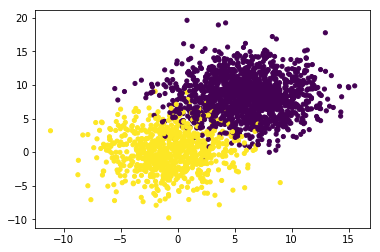

In [9]:
# X, y = make_blobs(n_samples=[2000, 1000], n_features=velicina_ulaza, centers=None, cluster_std=3)

# X_test = torch.tensor(X[0:len(X)//4], dtype=torch.float) 
# y_test = torch.tensor(y[0:len(y)//4], dtype=torch.float)
# X, y = X[len(X)//4:], y[len(y)//4:]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.28)


# X_train = torch.tensor(X_train, dtype=torch.float)
# y_train = torch.tensor(y_train, dtype=torch.float)

# X_val = torch.tensor(X_val, dtype=torch.float)
# y_val = torch.tensor(y_val, dtype=torch.float)


# plt.scatter(X[:,0], X[:,1], c=y, s=17, marker='o')

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, layers, alpha, momentum, lambda_, f = nn.Linear, act = nn.Sigmoid()):
        self.n_layers = len(layers)
        self.alpha = alpha
        self.momentum = momentum
        self.lambda_ = lambda_
        self.name = 'L-' + str(layers) + 'a-' + str(alpha) + 'm-' + str(momentum) + 'l-' + str(lambda_)

        super(NeuralNet, self).__init__()
        if inspect.isclass(f):
            f = (self.n_layers - 1) * [f]
        for i in range(self.n_layers - 1):
            self.__setattr__('fc{0:d}'.format(i), f[i](layers[i], layers[i + 1]))
        self.act = act

    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.act(self.__getattr__('fc{0:d}'.format(i))(x))
        return x

    def train(self, criterion = nn.BCELoss(), optimizer = None, n_epochs = 5000, batch_size = 10, eps = 1.0e-6):
        print('\n\n')
        print('Trening neuronske mreze sa parametrima alpha: {}, momentum: {}, lambda: {}'.format(alpha, momentum, lambda_))

        if optimizer is None:
            optimizer = optim.SGD(self.parameters(), lr=self.alpha, momentum=self.momentum, weight_decay=self.lambda_)

        losses = []
        prekini_trening = False

        for epoch in range(n_epochs):
            for i in range(0, len(X_train), batch_size):
                podaci = X_train[i:(i+batch_size), :]
                labele = y_train[i:(i+batch_size)].reshape(len(y_train[i:(i+batch_size)]), 1)

                podaci = Variable(podaci, requires_grad=True).to(device)
                labele = Variable(labele, requires_grad=False).to(device)

                # obrisi povijest operacija koje su se dogodile
                optimizer.zero_grad()

                # loss sadrzi sve operacije unazad (npr. input pa cijeli forward pa criterion) i na njemu
                # mozemo napraviti backpropagation preko funkcije backward
                outputs = self.forward(podaci)
                loss = criterion(outputs, labele)
                loss.backward()

                # updateaj novonastale weight-ove
                optimizer.step()

                # spremimo sve vrijednosti loss-eva
                if(i + batch_size >= len(X_train)):
                    greska = loss.data.cpu().numpy()

                    try:
                        prekini_trening = (max(abs(greska - l) for l in losses[-4:]) < eps)
                    except ValueError:
                        pass

                    losses.append(greska)
            
            if(prekini_trening):
                print("Trening konvergira u epohi {} sa loss-om: {}".format(epoch, losses[-1]))
                break
            
            if not epoch % 50:
                print("Epoch {} - loss: {}".format(epoch, losses[-1]))
            
            
            
        return losses
        


In [11]:
# dodati F1 score umjesto accuracy-a
## ipak samo racunati TP, FP, TN, FN
def accuracy(neural_net, X, y):
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(0, len(X), batch_size):
            predicted = neural_net.forward(X[i:i+batch_size, :].to(device))
            total += len(X[i:i+batch_size, :])

            for j in range(len(predicted)):
                predicted[j] = 0 if predicted[j] < 0.5 else 1

            correct += (predicted == y[i:i+batch_size].reshape(len(y[i:i+batch_size]), 1).to(device)).sum().item()

        return 100 * correct / total
    

# funkcija koja sortira listu neural_nets silazno po accuracy-u
def sortiraj_mreze(neural_nets, eval_of_nets):
    for i in range(len(eval_of_nets) - 1):
        for j in range(len(eval_of_nets) - i - 1):
            if(eval_of_nets[j] < eval_of_nets[j+1]):
                eval_of_nets[j], eval_of_nets[j+1] =  eval_of_nets[j+1], eval_of_nets[j]
                neural_nets[j], neural_nets[j+1] =  neural_nets[j+1], neural_nets[j]




Trening neuronske mreze sa parametrima alpha: 0.05, momentum: 0.85, lambda: 0
Epoch 0 - loss: 0.27719059586524963
Epoch 50 - loss: 0.15830235183238983
Epoch 100 - loss: 0.1532106250524521
Epoch 150 - loss: 0.15243367850780487
Epoch 200 - loss: 0.1497402787208557
Epoch 250 - loss: 0.14654949307441711
Epoch 300 - loss: 0.1389935463666916
Epoch 350 - loss: 0.13319525122642517
Epoch 400 - loss: 0.12775379419326782
Epoch 450 - loss: 0.12304112315177917
Epoch 500 - loss: 0.11874464154243469
Epoch 550 - loss: 0.11454318463802338
Epoch 600 - loss: 0.11070200055837631
Epoch 650 - loss: 0.10746133327484131
Epoch 700 - loss: 0.10455531626939774
Epoch 750 - loss: 0.10185132175683975
Epoch 800 - loss: 0.10041461884975433
Epoch 850 - loss: 0.09853022545576096
Epoch 900 - loss: 0.0961679071187973
Epoch 950 - loss: 0.09429788589477539
Epoch 1000 - loss: 0.09321106970310211
Epoch 1050 - loss: 0.09258737415075302
Epoch 1100 - loss: 0.0921008512377739
Epoch 1150 - loss: 0.09146369248628616
Epoch 1200 

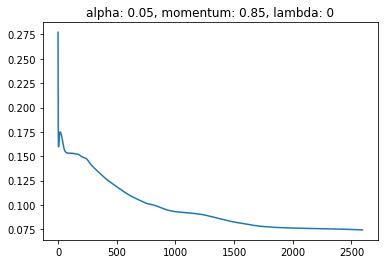

In [12]:
neural_nets  = []
eval_of_nets = []


# PROMIJENITI OVO SVE U NORMALNE VRIJEDNOSTI (na osnovu onih lista definiranih na pocetku biljeznice)
for layers in layers_combination:
    for alpha in [0.05]:
        for momentum in [0.85]:
            for lambda_ in [0]:
                neural_net = NeuralNet(layers, alpha, momentum, lambda_).to(device)
                losses = neural_net.train()

                # plotaj graf gresaka tijekom iteracija
                fig, ax = plt.subplots()
                ax.set_title('layer: ' + str(layer) + ', alpha: ' + str(neural_net.alpha) + ', momentum: ' + str(neural_net.momentum) + '\n lambda: ' + str(neural_net.lambda_))
                ax.plot(losses)
                fig.savefig(neural_net.name + '.png')

                # evaluiraj na validacijskom skupu i spremi tu mrezu u listu
                eval_of_nets += [accuracy(neural_net, X_val, y_val)]
                neural_nets += [neural_net]

In [7]:
# spremimo najbolje 3 mreze
sortiraj_mreze(neural_nets, eval_of_nets)

for neural_net in neural_nets[:3] :
    torch.save(neural_net.state_dict(), neural_net.name + '.pt')
    
eval_of_nets

[97.78129952456419]